# Objetivo

Avaliar o desempenho de uma rede neural artificial MLP e comparar com os modelos anteriores.

# Pacotes

In [7]:
#!pip install tensorflow

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
from deltalake import DeltaTable, write_deltalake
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

2025-01-19 15:56:49.634894: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 15:56:49.640726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 15:56:49.653562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737313009.672803   29081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737313009.678241   29081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 15:56:49.697832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Leitura da base v1 e filtro de variáveis

Variáveis com valor acumulado de importância em ~90% e pelo valor de IV.

In [2]:
dados = DeltaTable("../1.Variaveis/tmp/dados_pp_v1").to_pandas()
dados.drop(['__index_level_0__', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver', 
            'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Gender_M',
            'Dependent_count'], axis=1, inplace=True)
dados.head()

,Customer_Age,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,vfm,pmcc,Income_Category_1.< 40k,Income_Category_2. >= 40k & < 60k,Income_Category_3. >= 60k & < 80k,Income_Category_4. >= 80k & < 120k,Income_Category_5. >= 120k,Education_Level_v2_1.Uneducated,Education_Level_v2_2.High School,Education_Level_v2_3.Graduate,Education_Level_v2_4.Post-Graduate,Attrition_Flag,type
0,-0.784196,1.403132,-1.337898,0.498943,0.963894,0.282975,-0.328225,-0.175537,-0.421450,1,0,0,0,0,0,0,1,0,0,Treino
1,0.720070,-0.525933,0.641818,1.408428,-0.165769,-1.527806,-0.194304,-0.208685,-1.054789,0,0,0,1,0,0,0,1,0,0,Treino
2,1.346848,-0.525933,-0.348040,0.498943,0.864865,0.894171,0.056797,-0.571459,-0.686436,0,0,0,1,0,0,0,0,1,0,Treino
3,0.218648,-0.525933,0.641818,-1.320028,-0.412731,0.369637,0.851953,0.252749,2.406712,1,0,0,0,0,0,0,1,0,0,Treino
4,-2.539173,0.117089,1.631675,1.408428,-0.858972,0.346832,-1.144306,-0.064053,-0.071911,1,0,0,0,0,1,0,0,0,0,Treino


## Separa bases

In [3]:
dados_treino = dados[dados.type == 'Treino'].drop(['type'], axis=1)
dados_val = dados[dados.type == 'Validacao'].drop(['type'], axis=1)

In [4]:
X_treino = dados_treino.drop(['Attrition_Flag'], axis=1)
y_treino = dados_treino['Attrition_Flag']

X_val = dados_val.drop(['Attrition_Flag'], axis=1)
y_val = dados_val['Attrition_Flag']

In [5]:
X_treino_new = X_treino.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

X_val_new = X_val.rename(columns={'Income_Category_1.< 40k': 'Income_Category_1.40k',
                                        'Income_Category_2. >= 40k & < 60k': 'Income_Category_2.40k_60k',
                                        'Income_Category_3. >= 60k & < 80k': 'Income_Category_3.60k_80k',
                                        'Income_Category_4. >= 80k & < 120k': 'Income_Category_4.80k_120k',
                                        'Income_Category_5. >= 120k': 'Income_Category_5.120k'
                                        })

In [6]:
X_treino2, X_teste2, y_treino2, y_teste2 = train_test_split(X_treino_new, y_treino, test_size=.40, stratify=y_treino, random_state=1234)
y_treino2.value_counts(), y_teste2.value_counts()

(Attrition_Flag
 0    3684
 1     705
 Name: count, dtype: int64,
 Attrition_Flag
 0    2456
 1     470
 Name: count, dtype: int64)

In [7]:
X_treino2.shape

(4389, 18)

In [8]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(10, activation='tanh', input_shape=X_treino2.shape[1:]),
        keras.layers.Dropout(rate=.2),
        keras.layers.Dense(10, activation='tanh'),
        keras.layers.Dropout(rate=.2),
        keras.layers.Dense(5, activation='tanh'),
        keras.layers.Dropout(rate=.2),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-19 15:59:09.428293: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score, tf.keras.metrics.Precision, tf.keras.metrics.Recall])

In [ ]:
history = model.fit(X_treino2, y_treino2, epochs=150,validation_data=(X_teste2, y_teste2), batch_size=50)

Epoch 1/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.2871 - f1_score: 0.2894 - loss: 0.6570 - precision: 0.2597 - recall: 0.6729 - val_auc: 0.3941 - val_f1_score: 0.2768 - val_loss: 0.5095 - val_precision: 0.3978 - val_recall: 0.4723
Epoch 2/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.2999 - f1_score: 0.2684 - loss: 0.5108 - precision: 0.3407 - recall: 0.4198 - val_auc: 0.4443 - val_f1_score: 0.2768 - val_loss: 0.4339 - val_precision: 0.5805 - val_recall: 0.2532
Epoch 3/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.2760 - f1_score: 0.2622 - loss: 0.4577 - precision: 0.3407 - recall: 0.2087 - val_auc: 0.4798 - val_f1_score: 0.2768 - val_loss: 0.4009 - val_precision: 0.7712 - val_recall: 0.1936
Epoch 4/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.3728 - f1_score: 0.2837 - loss: 0.4283 - precision: 0.5490 - recall: 0.2080 - val_auc: 0.5050 - val_f1_score: 0.2768 - val_loss: 0.3841 - val_precision: 0.8554 - val_recall: 0.1511
Epoch 5/150
88/88 ━━━━━━━━━━━━━━━━━━

In [12]:
model.evaluate(X_val_new, y_val)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6549 - f1_score: 0.2844 - loss: 0.3109 - precision: 0.7398 - recall: 0.4706


[0.31849297881126404,
 0.6083055734634399,
 0.2773333191871643,
 0.7099236845970154,
 0.44711539149284363]

In [22]:
history.history

{'auc': [0.27812662720680237,
  0.30388081073760986,
  0.31932058930397034,
  0.346180260181427,
  0.3950744867324829,
  0.404051274061203,
  0.4244793653488159,
  0.4417797923088074,
  0.41763997077941895,
  0.460907518863678,
  0.48862308263778687,
  0.47506800293922424,
  0.491094708442688,
  0.4932432174682617,
  0.4991109371185303,
  0.4965166747570038,
  0.4872002601623535,
  0.5182613134384155,
  0.540385365486145,
  0.5096774101257324,
  0.5364768505096436,
  0.5412313938140869,
  0.53931725025177,
  0.5212897062301636,
  0.535036027431488,
  0.543817937374115,
  0.549857497215271,
  0.5437806248664856,
  0.5213578939437866,
  0.551167905330658,
  0.5475139617919922,
  0.5439276695251465,
  0.5398401021957397,
  0.5501810312271118,
  0.5473690032958984,
  0.5638861060142517,
  0.5352585911750793,
  0.5537394285202026,
  0.5542385578155518,
  0.5616198182106018,
  0.5704324245452881,
  0.5729326605796814,
  0.5694517493247986,
  0.5658361315727234,
  0.5662519931793213,
  0.5475

In [ ]:
main_metrics = {   
                    'tr_aucpr': history.history['auc'],
                    'vl_aucpr': history.history['val_auc']
                }

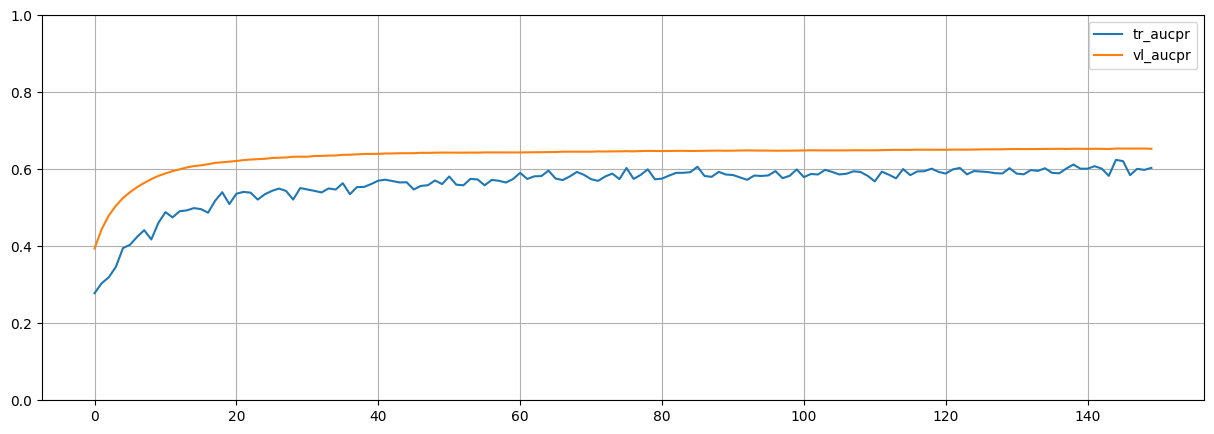

In [31]:
pd.DataFrame(main_metrics).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.legend(loc='upper right')
plt.show()